In [1]:
import pandas as pd
import numpy as np

import glob, os

In [2]:
### Set paths and file names
path_raw = "data/raw/TRTH/equities/US/"
path_clean = "data/clean/TRTH/equities/US/"

# List of the files
allfiles_trade=glob.glob(os.path.join(path_raw,"trade/AAPL.OQ/*"))
allfiles_bbo=glob.glob(os.path.join(path_raw,"bbo/AAPL.OQ/*"))

# Only keeps the 5 first to begin with
allfiles_trade=np.sort(allfiles_trade)[:3]
allfiles_bbo=np.sort(allfiles_bbo)[:3]

In [3]:
### Functions 
def type_is_not_None(obj):
    if type(obj) is type(None) : return False
    return True


### Functions that can be used with parallel computing
import dask
dask.config.set(scheduler="processes")

@dask.delayed
def load_TRTH_trade(filename,
             tz_exchange="America/New_York",
             only_non_special_trades=True,
             only_regular_trading_hours=True,
             open_time="09:30:00",
             close_time="16:00:00",
             merge_sub_trades=True):
    
    DF = pd.read_csv(filename)
    if (DF.empty == True) : return None

    if only_non_special_trades:
        DF = DF[DF["trade-stringflag"]=="uncategorized"]

    DF.drop(columns=["trade-rawflag","trade-stringflag"],axis=1,inplace=True)
    
    DF.index = pd.to_datetime(DF["xltime"],unit="D",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time(open_time,close_time)    # warning: ever heard e.g. about Thanksgivings?
    
    if merge_sub_trades:
           DF=DF.groupby(DF.index).agg(trade_price=pd.NamedAgg(column='trade-price', aggfunc='mean'),
                                       trade_volume=pd.NamedAgg(column='trade-volume', aggfunc='sum'))
    
    return DF

@dask.delayed
def load_TRTH_bbo(filename,
             tz_exchange="America/New_York",
             open_time="09:30:00",
             close_time="16:00:00",
             only_regular_trading_hours=True):
    
    DF = pd.read_csv(filename)
    if (DF.empty == True) : return None

    DF.index = pd.to_datetime(DF["xltime"],unit="D",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time(open_time,close_time)    # warning: ever heard e.g. about Thanksgivings?
        
    return DF

In [4]:
### Load/treat/regroup/save the DF
# Load the TRTH data
allpromises_trade=[load_TRTH_trade(fn) for fn in allfiles_trade]
allpromises_bbo=[load_TRTH_bbo(fn) for fn in allfiles_bbo]

# Compute with dask
alltrades=dask.compute(allpromises_trade)[0]            
allbbos=dask.compute(allpromises_bbo)[0]    

# Remove the None from the empty DF
alltrades = list(filter(type_is_not_None,alltrades))
allbbos = list(filter(type_is_not_None,allbbos))

# Regroup the DF
alltrades=pd.concat(alltrades)
allbbos=pd.concat(allbbos)

# Join them together
allevents=alltrades.join(allbbos,how='inner')

# Fill the DF
allevents.ffill(inplace=True)

# Save the cleaned DF
if (not os.path.exists(path_clean)):
    os.makedirs(path_clean)
allevents.to_csv(os.path.join(path_clean,"AAPL.OQ.csv.gz"))

In [16]:
## Sets up a dataframe for the ML algorithm
from datetime import timedelta

N=len(allevents)

# Parameters for the ML
SimData = pd.DataFrame(index=allevents.index)
SimData['total-traded'] = allevents['trade_price']*allevents['trade_volume']
SimData['bid-ask-spread'] = allevents['bid-price']-allevents['ask-price']

# Evolution for the trade-price after 1s
# returns 1 if the trade-price increased, 0 otherwise
tmp = np.zeros(N)
for i in range(N):
    dt = allevents.index[i]
    for j in range(i,N):
        if (allevents.index[j]>=dt+timedelta(seconds=1)):
            tmp[i] = (allevents.iloc[j]['trade_price']<allevents.iloc[i]['trade_price'])
            break
SimData['1s-change'] = tmp

In [17]:
### Split data for training and validation
from sklearn.model_selection import train_test_split

array = SimData.values
X = array[:,0:1] # for the 2 parameters
y = array[:,2] # for trade_price increase prediction

X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=None)

In [18]:
### Use a Decision Tree Classifier for prediction 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

Accuracy of the prediction : 
0.7472635120746198
Confusion matrix, without normalization
[[11079  2016]
 [ 3918  6466]]
Normalized confusion matrix
[[0.84604811 0.15395189]
 [0.37731125 0.62268875]]


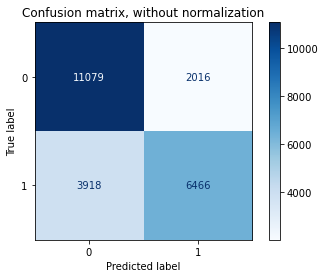

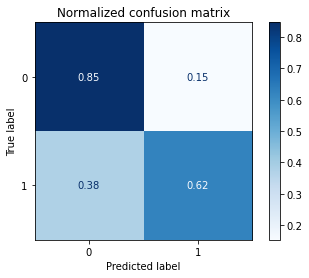

Classification report : 
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79     13095
         1.0       0.76      0.62      0.69     10384

    accuracy                           0.75     23479
   macro avg       0.75      0.73      0.74     23479
weighted avg       0.75      0.75      0.74     23479



In [43]:
### Evaluates the predictions
# Accuracy
print("Accuracy of the prediction : \n" + str(accuracy_score(Y_validation, predictions)))


# Confusion matrices
from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_validation, Y_validation,
                                 display_labels=['0','1'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


# Classification report
print("Classification report : ")
print(classification_report(Y_validation, predictions))